# Stanton Murillo Transport Validation and Improved XC Correction

[1] "Ionic transport in high-energy-density matter"  [10.1103/PhysRevE.93.043203](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.93.043203)

[2]"Efficient model for electronic transport in high energy-density matter "  [https://doi.org/10.1063/5.0048162](https://doi.org/10.1063/5.0048162)

[3]"Rapid ..." [https:...]

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pandas import read_csv

import sys
sys.path.insert(0, "C:\\Users\zachc\Documents\GitHub")
import SMT.core.transport as SMT
from SMT.core.physical_constants import *
from SMT.core.physical_parameters import rs_from_n, Degeneracy_Parameter

import matplotlib.pyplot as plt
import matplotlib as mpl

from cycler import cycler


mpl.rcParams['lines.linewidth'] = 2.2
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['font.sans-serif'] = ['Arial', 'Tahoma', 'DejaVu Sans', 'Lucida Grande', 'Verdana']
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = '#636363'
mpl.rcParams['grid.alpha'] = 0.12
mpl.rcParams['grid.linewidth'] = 0.7
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['axes.prop_cycle'] = cycler('color',  ['#0AB34F', '#bf009f', '#00abc3', '#8e92c5', '#cc7014', '#e32851'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.framealpha'] = 0.6
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.figsize'] = 8, 4.9443
mpl.rcParams['figure.dpi'] = 100

## Define Useful transport function

In [2]:
def get_transport_functions(Z, A, ni_cc, xc_type=None, λdB=False, ae=False, PB = False):

    if xc_type==None:
        smt = SMT.TransportProperties(1, np.array([m_amu*A]), np.array([Z]), np.array([1*eV_to_AU, 1*eV_to_AU ]), np.array([ni_cc])*invcc_to_AU, improved_xc_SMT=False, improved_λdB_SMT=λdB, improved_ae_SMT=ae , λdB_n=λdB_n, improved_PauliBlocking = PB)
    else:
        smt = SMT.TransportProperties(1, np.array([m_amu*A]), np.array([Z]), np.array([1*eV_to_AU, 1*eV_to_AU ]), np.array([ni_cc])*invcc_to_AU, improved_xc_SMT=True, improved_λdB_SMT=λdB, improved_ae_SMT=ae, xc_type='YOT', λdB_n=λdB_n, improved_PauliBlocking = PB)

    # All out in cgs
    @np.vectorize
    def ηSMT(T_eV):
        T_AU = T_eV*eV_to_AU
        smt.T_array = np.array([T_AU, T_AU])
        return smt.viscosity()*AU_to_g*AU_to_invcc*AU_to_cm**2/AU_to_s
    
    @np.vectorize
    def ηYVM(T_eV):
        yvm = YVM(smt.mi_array*AU_to_g, smt.mi_array*AU_to_g*smt.ni_array*AU_to_invcc, T_eV, Z, units_out='cgs')
        return yvm.viscosity_YVM()

    @np.vectorize
    def κiSMT(T_eV):
        T_AU = T_eV*eV_to_AU
        smt.T_array = np.array([T_AU, T_AU])
        return smt.κi* AU_to_erg/(AU_to_cm*AU_to_s*AU_to_K)
 
    @np.vectorize
    def κeSMT(T_eV):
        T_AU = T_eV*eV_to_AU
        smt.T_array = np.array([T_AU, T_AU])
        return smt.κee* AU_to_erg/(AU_to_cm*AU_to_s*AU_to_K)
    
    @np.vectorize
    def σeSMT(T_eV):
        T_AU = T_eV*eV_to_AU
        smt.T_array = np.array([T_AU, T_AU])
        return smt.σ* AU_to_Siemens/AU_to_cm
    
    @np.vectorize
    def λeff(T_eV):
        T_AU = T_eV*eV_to_AU
        smt.T_array = np.array([T_AU, T_AU])
        return smt.λeff

    @np.vectorize
    def λ_params(T_eV):
        T_AU = T_eV*eV_to_AU
        smt.T_array = np.array([T_AU, T_AU])
        λi_eff = 1/np.sqrt(np.sum( 1/(smt.λi_array**2 + smt.ri_eff**2)))
        θ = Degeneracy_Parameter(smt.Te, smt.ne)
        return smt.λe, λi_eff, θ, smt.f_dB, smt.K_11_matrix[0,1]

    return ηSMT, ηYVM, κiSMT, κeSMT, σeSMT, λeff, λ_params


## Electrical Conductivity

First, loading data from [2]

In [3]:
σ_data_e1b_SMT = read_csv("Fig1b_eSMT_σ.txt", delim_whitespace=True, header=1)
σ_data_e1b_LM = read_csv("Fig1b_eSMT_σ_LM.txt", delim_whitespace=True, header=1)
σ_data_e1b_Top = read_csv("Fig1b_eSMT_σ_Top_Other.txt", delim_whitespace=True, header=1)
σ_data_e1b_Bot = read_csv("Fig1b_eSMT_σ_Bot_Other.txt", delim_whitespace=True, header=1)

In [16]:
# H
Element_name = 'H'
Z, A = 1, 1.00784
ρi_gpercc  = 1
ni_cc = ρi_gpercc/(m_amu*A*AU_to_g)

λdB_n = 2

SMT_H_funcs = get_transport_functions(Z,A,ni_cc)
SMTPB_H_funcs = get_transport_functions(Z,A,ni_cc,PB=True )
SMTYOT_H_funcs = get_transport_functions(Z,A,ni_cc, xc_type='YOT')
SMTλdB_H_funcs = get_transport_functions(Z,A,ni_cc, λdB = True )
SMTYOTλdB_H_funcs = get_transport_functions(Z,A,ni_cc, λdB = True, xc_type='YOT' )
SMTaeλdB_H_funcs = get_transport_functions(Z,A,ni_cc, λdB = True, ae=True )
SMTaeYOTλdB_H_funcs = get_transport_functions(Z,A,ni_cc, λdB = True, ae=True , xc_type='YOT' )
SMTPBaeYOTλdB_H_funcs = get_transport_functions(Z,A,ni_cc, λdB = True, ae=True , xc_type='YOT' , PB=True)


C:\Users\zachc\Documents\GitHub\SMT\core\physical_parameters.py:126: RuntimeWarning: overflow encountered in cosh
  sech = lambda x: 1/np.cosh(x)


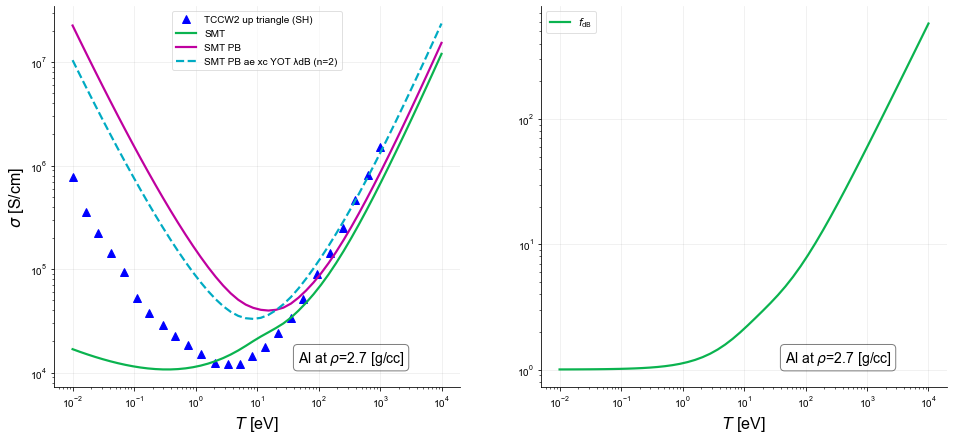

In [28]:
# T_AU_list = np.geomspace(1e-1,1e4,num=100)*eV_to_AU

fig, axs = plt.subplots(1,2, figsize=(16,7), facecolor='white')
# if type(axs) not in [list, np.array]:
#     axs = np.array([axs])
ax = axs[0]
# Plot digitized eSMT data
TeV_list = np.geomspace(1e-2,1e4)
# ax.plot(σ_data_e1b_SMT['T[eV]'], σ_data_e1b_SMT['σ[S/cm]'],'k:', label="Digitized eSMT data")
# ax.plot(σ_data_e1b_LM['T[eV]'], σ_data_e1b_LM['σ[S/cm]'],'g^', label="Digitized eSMT LM data")
# ax.fill_between(σ_data_e1b_Top['T[eV]'], σ_data_e1b_Bot['σ[S/cm]'], σ_data_e1b_Top['σ[S/cm]'],color='k',alpha=0.2,label='Digitized eSMT data spread')

TCCW2_H_σ_uptri = read_csv("TCCW2_Fig6a_SH.txt", delim_whitespace=True, header=1)
ax.plot(TCCW2_H_σ_uptri['T[eV]'], TCCW2_H_σ_uptri['σ[S/cm]'],'b^', label='TCCW2 up triangle (SH)')

ax.plot(TeV_list, SMT_H_funcs[4](TeV_list), label='SMT')
ax.plot(TeV_list, SMTPB_H_funcs[4](TeV_list), label='SMT PB')
# ax.plot(TeV_list, SMTλdB_H_funcs[4](TeV_list), label='SMT λdB')
# ax.plot(TeV_list, SMTaeλdB_H_funcs[4](TeV_list), label=f'SMT ae λdB (n={λdB_n})')
# ax.plot(TeV_list, SMTYOT_H_funcs[4](TeV_list),'--', label='SMT xc')
# ax.plot(TeV_list, SMTYOTλdB_H_funcs[4](TeV_list),'--', label=f'SMT xc λdB (n={λdB_n})')
# ax.plot(TeV_list, SMTaeYOTλdB_H_funcs[4](TeV_list),'--', label=f'SMT ae xc λdB (n={λdB_n})')
ax.plot(TeV_list, SMTPBaeYOTλdB_H_funcs[4](TeV_list),'--', label=f'SMT PB ae xc YOT λdB (n={λdB_n})')
# ax.plot(TeV_list, 10*TeV_list**(1.5),'r:', label=r'$T^{3/2}$')
ax.set_ylabel(r"$\sigma$ [S/cm]")
# 
ax = axs[1]
# ax.plot(TeV_list, SMTλdB_H_funcs[6](TeV_list)[3]/SMTλdB_H_funcs[6](TeV_list)[2], label=r'$r_c/\lambda_{dB}$')
# ax.plot(TeV_list, SMTλdB_H_funcs[4](TeV_list)/SMT_H_funcs[4](TeV_list), label='SMTdB/SMT')
ax.plot(TeV_list, SMTλdB_H_funcs[6](TeV_list)[-2], label=r'$f_{\rm dB}$')
# ax.plot(TeV_list, SMTλdB_H_funcs[6](TeV_list)[-1], label=r'$K_{11}(g_{ei})$')
# ax.plot(TeV_list, SMTλdB_H_funcs[6](TeV_list)[0]/SMTλdB_H_funcs[5](TeV_list), label=r'$\lambda_e/\lambda_{\rm eff}$')
# ax.plot(TeV_list, SMTλdB_H_funcs[6](TeV_list)[1]/SMTλdB_H_funcs[5](TeV_list), label=r'$\lambda_i^{\rm eff}/\lambda_{\rm eff}$')
# ax.plot(TeV_list, SMTYOTλdB_H_funcs[4](TeV_list)/SMT_H_funcs[4](TeV_list), label=r'$\sigma(YOT+\lambda_{dB})/\sigma$')
# ax.plot(TeV_list, SMTλdB_H_funcs[6](TeV_list)[4], label=r'$\theta$')
# ax.set_ylabel("Parameter")

for ax in axs:
    ax.set_xlabel(r"$T$ [eV]")
    
    # Inset Text Box
    bbox = dict(boxstyle='round', facecolor='white', alpha=0.5)
    inset_text = f"{Element_name} at " r"$\rho$" + f"={ρi_gpercc} [g/cc]" 
    ax.text(0.6, 0.1, inset_text, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=bbox)
    
    # Scales
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    # Legend
    ax.legend()



## Thermal Conductivity

#### SMT

C:\Users\zachc\AppData\Local\Temp/ipykernel_5508/2517681312.py:6: RuntimeWarning: overflow encountered in exp
  f_fd = lambda eps: 1/(1 + np.exp(eps-eta))
C:\Users\zachc\AppData\Local\Temp/ipykernel_5508/2517681312.py:13: RuntimeWarning: overflow encountered in exp
  f_fd = lambda eps: 1/(1 + np.exp(eps-eta))


[0.52035809 1.2766832  1.83874532]


(1.0959596793105735, 1000.0)

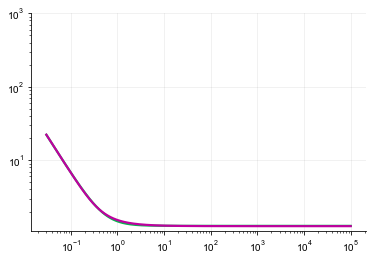

In [6]:
from scipy.integrate import quad
from scipy.optimize import curve_fit

@np.vectorize
def sigma_integral(eta):    
    f_fd = lambda eps: 1/(1 + np.exp(eps-eta))  
    integral = lambda eps: f_fd(eps)*np.sqrt(eps)
    int_of_theta = quad(integral, 0, 1e4 )
    return int_of_theta[0]

@np.vectorize
def sigma_integral_PB(eta):    
    f_fd = lambda eps: 1/(1 + np.exp(eps-eta))  
    integral = lambda eps: (1-f_fd(eps))*f_fd(eps)*np.sqrt(eps)
    int_of_theta = quad(integral, 0, 1e4 )
    return int_of_theta[0]

fig, ax  = plt.subplots()

theta_array = np.geomspace(3e-2,1e5, num=1000)
sigma_f = sigma_integral(1/theta_array)
sigma_f_PB = sigma_integral_PB(1/theta_array)


# a=1
# b=1.5
# c=0.99
# n=2
f_approx = lambda theta, a, b, n: b*(1 + (a/theta)**n)**(1/n)
popt, pcov = curve_fit(f_approx,theta_array, sigma_f/sigma_f_PB, p0=[1, 1,1] ) 
print(popt)
ax.plot(theta_array, f_approx(theta_array, *popt))
# ax.plot(theta_array, f_approx(theta_array, 1,1))
ax.plot(theta_array, sigma_f/sigma_f_PB)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(None,1e3)


In [7]:
κ_data_e3b = read_csv("Fig3b_eSMT_κ.txt", delim_whitespace=True, header=1)

In [8]:
# H
Element_name = 'H'
Z, A = 1, 1.00784
ρi_gpercc  = 1
ni_cc = ρi_gpercc/(m_amu*A*AU_to_g)

λdB_n = 2

SMT_H_funcs = get_transport_functions(Z,A,ni_cc)
SMTYOT_H_funcs = get_transport_functions(Z,A,ni_cc, xc_type='YOT')
SMTλdB_H_funcs = get_transport_functions(Z,A,ni_cc, λdB = True )
SMTYOTλdB_H_funcs = get_transport_functions(Z,A,ni_cc, λdB = True, xc_type='YOT' )
# SMTPBYOTλdB_H_funcs = get_transport_functions(Z,A,ni_cc, λdB = True, xc_type='YOT', PB=True )


C:\Users\zachc\Documents\GitHub\SMT\core\physical_parameters.py:126: RuntimeWarning: overflow encountered in cosh
  sech = lambda x: 1/np.cosh(x)


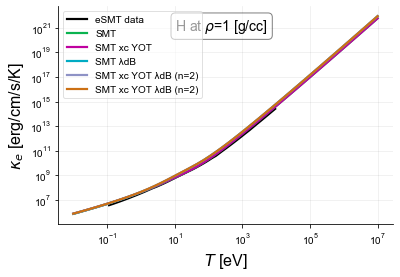

In [9]:
fig, ax = plt.subplots( facecolor='white')

# Plot digitized eSMT data
ax.plot(κ_data_e3b['T[eV]'], κ_data_e3b['κ[erg/cm/s/K]'],'k-', label="eSMT data")

ax.plot(TeV_list, SMT_H_funcs[3](TeV_list), label='SMT')
ax.plot(TeV_list, SMTYOT_H_funcs[3](TeV_list), label='SMT xc YOT')
ax.plot(TeV_list, SMTλdB_H_funcs[3](TeV_list), label='SMT λdB')
ax.plot(TeV_list, SMTYOTλdB_H_funcs[3](TeV_list), label=f'SMT xc YOT λdB (n={λdB_n})')
ax.plot(TeV_list, SMTYOTλdB_H_funcs[3](TeV_list), label=f'SMT xc YOT λdB (n={λdB_n})')
# ax.plot(TeV_list, SMTPBYOTλdB_H_funcs[3](TeV_list), label=f'SMT PB xc YOT λdB (n={λdB_n})')


# Inset Text Box
bbox = dict(boxstyle='round', facecolor='white', alpha=0.5)
inset_text = f"{Element_name} at " r"$\rho$" + f"={ρi_gpercc} [g/cc]" 
ax.text(0.35, 0.95, inset_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=bbox)

ax.set_ylabel(r"$\kappa_e$ [erg/cm/s/K]")
ax.set_xlabel(r"$T$ [eV]")

# Scales
ax.set_yscale('log')
ax.set_xscale('log')

# Legend
ax.legend()


## Aluminum

In [23]:
# Al
Element_name = 'Al'
Z, A = 13, 26.981539
ρi_gpercc  = 2.7
ni_cc = ρi_gpercc/(m_amu*A*AU_to_g)

λdB_n = 2

SMT_Al_funcs = get_transport_functions(Z,A,ni_cc)
SMTPB_Al_funcs = get_transport_functions(Z,A,ni_cc,PB=True )
SMTYOT_Al_funcs = get_transport_functions(Z,A,ni_cc, xc_type='YOT')
SMTλdB_Al_funcs = get_transport_functions(Z,A,ni_cc, λdB = True )
SMTYOTλdB_Al_funcs = get_transport_functions(Z,A,ni_cc, λdB = True, xc_type='YOT' )
SMTaeλdB_Al_funcs = get_transport_functions(Z,A,ni_cc, λdB = True, ae=True )
SMTaeYOTλdB_Al_funcs = get_transport_functions(Z,A,ni_cc, λdB = True, ae=True , xc_type='YOT' )
SMTPBaeYOTλdB_Al_funcs = get_transport_functions(Z,A,ni_cc, λdB = True, ae=True , xc_type='YOT' , PB=True)


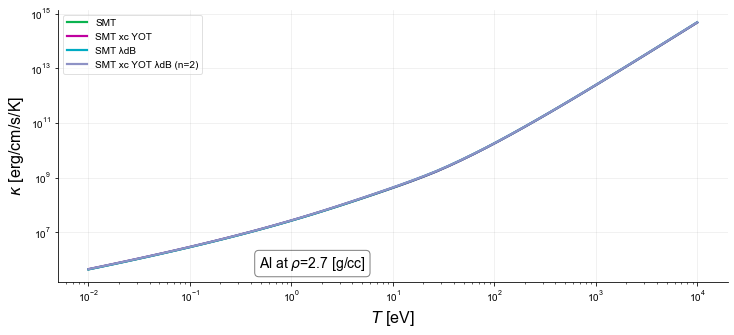

In [24]:
fig, axs = plt.subplots(1,1, figsize=(12,5), facecolor='white')
axs = np.array([axs])

# Plot digitized eSMT data
# ax.plot(κ_data_e3b['T[eV]'], κ_data_e3b['κ[erg/cm/s/K]'],'k-', label="eSMT data")
ax = axs[0]
TeV_list = np.geomspace(1e-2,1e4)

ax.plot(TeV_list, SMT_Al_funcs[3](TeV_list), label='SMT')
ax.plot(TeV_list, SMTYOT_Al_funcs[3](TeV_list), label='SMT xc YOT')
ax.plot(TeV_list, SMTλdB_Al_funcs[3](TeV_list), label='SMT λdB')
ax.plot(TeV_list, SMTYOTλdB_Al_funcs[3](TeV_list), label=f'SMT xc YOT λdB (n={λdB_n})')
ax.set_ylabel(r"$\kappa$ [erg/cm/s/K]")

# ax = axs[1]
# ax.plot(TeV_list, SMTλdB_Al_funcs[6](TeV_list)[3]/SMTλdB_Al_funcs[6](TeV_list)[2], label=r'$r_c/\lambda_{dB}$')
# ax.plot(TeV_list, SMTλdB_Al_funcs[6](TeV_list)[0]/SMTλdB_Al_funcs[5](TeV_list), label=r'$\lambda_e/\lambda_{\rm eff}$')
# ax.plot(TeV_list, SMTλdB_Al_funcs[6](TeV_list)[1]/SMTλdB_Al_funcs[5](TeV_list), label=r'$\lambda_i^{\rm eff}/\lambda_{\rm eff}$')
# ax.plot(TeV_list, SMTYOTλdB_Al_funcs[4](TeV_list)/SMT_Al_funcs[4](TeV_list), label=r'$\sigma(YOT+\lambda_{dB})/\sigma$')
# ax.plot(TeV_list, SMTλdB_Al_funcs[6](TeV_list)[4], label=r'$\theta$')
# ax.set_ylabel("Parameter")

for ax in axs:

    ax.set_xlabel(r"$T$ [eV]")
    
    # Scales
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    # Legend
    ax.legend()
    # Inset Text Box
    bbox = dict(boxstyle='round', facecolor='white', alpha=0.5)
    inset_text = f"{Element_name} at " r"$\rho$" + f"={ρi_gpercc} [g/cc]" 
    ax.text(0.3, 0.1, inset_text, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=bbox)



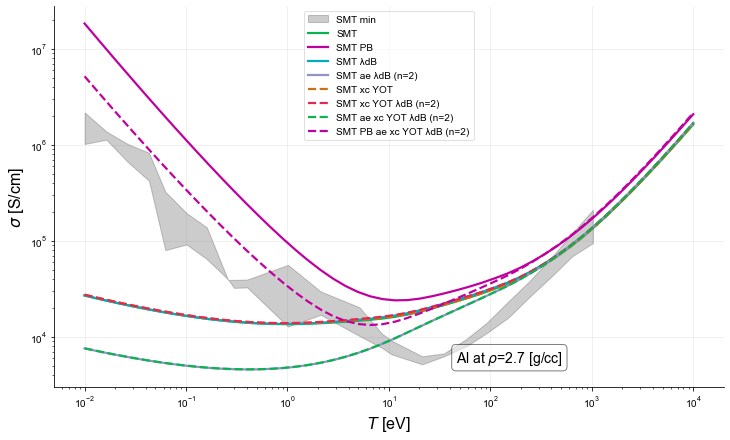

In [25]:
from scipy.interpolate import CubicSpline, PchipInterpolator


fig, axs = plt.subplots(1,1, figsize=(12,7), facecolor='white')
if type(axs) not in [list, np.array]:
    axs = np.array([axs])
ax = axs[0]
# Plot digitized eSMT data
TeV_list = np.geomspace(1e-2,1e4)
TCCW2_Al_σ_bot = read_csv("TCCW2_Fig6c_Bottom.txt", delim_whitespace=True, header=1)
TCCW2_Al_σ_top = read_csv("TCCW2_Fig6c_Top.txt", delim_whitespace=True, header=1)
ax.fill_between(TCCW2_Al_σ_bot['T[eV]'], TCCW2_Al_σ_bot['σ[S/cm]'], PchipInterpolator(TCCW2_Al_σ_top['T[eV]'],TCCW2_Al_σ_top['σ[S/cm]'])(TCCW2_Al_σ_bot['T[eV]']), label='SMT min',alpha=0.2,color='k')


ax.plot(TeV_list, SMT_Al_funcs[4](TeV_list), label='SMT')
ax.plot(TeV_list, SMTPB_Al_funcs[4](TeV_list), label='SMT PB')
ax.plot(TeV_list, SMTλdB_Al_funcs[4](TeV_list), label='SMT λdB')
ax.plot(TeV_list, SMTaeλdB_Al_funcs[4](TeV_list), label=f'SMT ae λdB (n={λdB_n})')
ax.plot(TeV_list, SMTYOT_Al_funcs[4](TeV_list),'--', label='SMT xc YOT')
ax.plot(TeV_list, SMTYOTλdB_Al_funcs[4](TeV_list),'--', label=f'SMT xc YOT λdB (n={λdB_n})')
ax.plot(TeV_list, SMTaeYOTλdB_Al_funcs[4](TeV_list),'--', label=f'SMT ae xc YOT λdB (n={λdB_n})')
ax.plot(TeV_list, SMTPBaeYOTλdB_Al_funcs[4](TeV_list),'--', label=f'SMT PB ae xc YOT λdB (n={λdB_n})')
ax.set_ylabel(r"$\sigma$ [S/cm]")

# ax = axs[1]
# # ax.plot(TeV_list, SMTλdB_H_funcs[6](TeV_list)[3]/SMTλdB_H_funcs[6](TeV_list)[2], label=r'$r_c/\lambda_{dB}$')
# ax.plot(TeV_list, SMTλdB_H_funcs[6](TeV_list)[0], label=r'$\lambda_e$')
# # ax.plot(TeV_list, SMTλdB_H_funcs[6](TeV_list)[0]/SMTλdB_H_funcs[5](TeV_list), label=r'$\lambda_e/\lambda_{\rm eff}$')
# # ax.plot(TeV_list, SMTλdB_H_funcs[6](TeV_list)[1]/SMTλdB_H_funcs[5](TeV_list), label=r'$\lambda_i^{\rm eff}/\lambda_{\rm eff}$')
# # ax.plot(TeV_list, SMTYOTλdB_H_funcs[4](TeV_list)/SMT_H_funcs[4](TeV_list), label=r'$\sigma(YOT+\lambda_{dB})/\sigma$')
# # ax.plot(TeV_list, SMTλdB_H_funcs[6](TeV_list)[4], label=r'$\theta$')
# ax.set_ylabel("Parameter")

for ax in axs:
    ax.set_xlabel(r"$T$ [eV]")
    
    # Inset Text Box
    bbox = dict(boxstyle='round', facecolor='white', alpha=0.5)
    inset_text = f"{Element_name} at " r"$\rho$" + f"={ρi_gpercc} [g/cc]" 
    ax.text(0.6, 0.1, inset_text, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=bbox)
    
    # Scales
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    # Legend
    ax.legend()

